In [1]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
from __future__ import division

In [2]:
OUTPUT_DIR = 'output/'
# Style image
STYLE_IMAGE = 'data/StarryNight.jpg'
# Content image to be repainted
CONTENT_IMAGE = 'data/Marilyn_Monroe_in_1952.jpg'


In [3]:
# how much noise is in the image
NOISE_RATIO = 0.6
# How much emphasis on content loss.
BETA = 5
# How much emphasis on style loss.
ALPHA = 100
# the VGG 19-layer pre-trained model 
VGG_MODEL = 'data/imagenet-vgg-verydeep-19.mat'
# The mean used when the VGG was trained 
# It is subtracted from the input to the VGG model. 
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

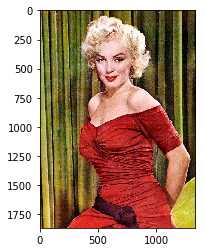

In [4]:
content_image = scipy.misc.imread(CONTENT_IMAGE)
imshow(content_image)

target_shape= (1865, 1335, 3)
style_shape= (1865, 1335, 3)


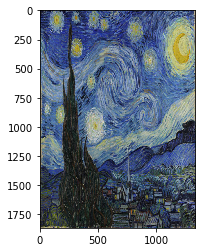

In [5]:
style_image = scipy.misc.imread(STYLE_IMAGE)
# Get shape of target and make the style image the same
target_shape = content_image.shape
print "target_shape=", target_shape
print "style_shape=", style_image.shape
#ratio = target_shape[1] / style_image.shape[1]
#print "resize ratio=", ratio
style_image = scipy.misc.imresize(style_image, target_shape)
scipy.misc.imsave(STYLE_IMAGE, style_image)
imshow(style_image)

In [6]:
def load_vgg_model(path, image_height, image_width, color_channels):
    """
    Returns the VGG model as defined in the paper
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        assert layer_name == expected_layer_name
        return W, b
    
    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 
                                             image_height, image_width, color_channels)), 
                                   dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [7]:
def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(p, x):
        # N is the number of filters (at layer l).
        N = p.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = p.shape[1] * p.shape[2]
        
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
    return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l).
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss


In [9]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """ 
    noise_image = np.random.uniform(
            -20, 20,
            (1, 
             content_image[0].shape[0], 
             content_image[0].shape[1],
             content_image[0].shape[2])).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def process_image(image):
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [10]:
sess = tf.InteractiveSession()

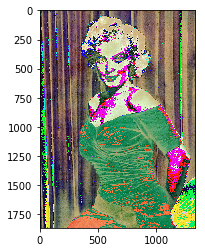

In [11]:
content_image = process_image(content_image)
imshow(content_image[0])

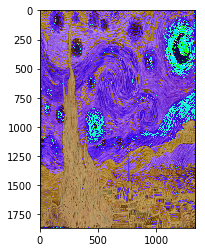

In [12]:
style_image = process_image(style_image)
imshow(style_image[0])

In [13]:
model = load_vgg_model(VGG_MODEL, style_image[0].shape[0], style_image[0].shape[1], style_image[0].shape[2])
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 1865, 1335, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 1865, 1335, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 117, 84, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 117, 84, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 117, 84, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 117, 84, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 234, 167, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 234, 167, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 234, 167, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 234, 167, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 467, 334, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 467, 334, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 467, 334, 256) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' sh

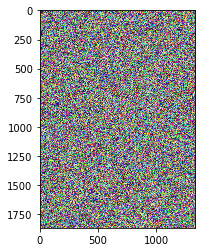

In [14]:
# Generate the white noise and content presentation mixed image
# which will be the basis for the algorithm to "paint".
input_image = generate_noise_image(content_image)
imshow(input_image[0])

In [15]:
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [16]:
# Construct content_loss using content_image.
sess.run(model['input'].assign(content_image))
content_loss = content_loss_func(sess, model)

In [17]:
# Construct style_loss using style_image.
sess.run(model['input'].assign(style_image))
style_loss = style_loss_func(sess, model)

In [18]:
# Instantiate equation 7 of the paper.
total_loss = BETA * content_loss + ALPHA * style_loss

In [19]:
# From the paper: jointly minimize the distance of a white noise image
# from the content representation of the photograph in one layer of
# the neywork and the style representation of the painting in a number
# of layers of the CNN.
#
# The content is built from one layer, while the style is from five
# layers. Then we minimize the total_loss, which is the equation 7.
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

In [20]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))


Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([[[[ 25.71688461,  14.76316452, -14.95469475],
         [ 33.06121445,  28.5269146 , -24.44714165],
         [ 28.24665451,  27.7004776 , -11.98849964],
         ..., 
         [-25.47951698, -17.29100418, -29.62818146],
         [-30.79752159, -29.50971222, -34.3741951 ],
         [-33.19865799, -39.41264725, -36.64604568]],

        [[ 23.29794502,  16.38306999, -24.99327278],
         [ 20.85736847,  11.32584667, -13.03267384],
         [ 32.75484085,  27.36659622, -10.01128101],
         ..., 
         [-36.47671127, -46.18558884, -48.12427139],
         [-30.47082901, -17.55398941, -22.32625198],
         [-25.30918884, -36.0356102 , -31.08044624]],

        [[ 29.17698479,  28.10607338, -16.40705681],
         [ 30.34549332,  16.68333054, -15.63034725],
         [ 30.04231644,  15.93176079, -21.60160446],
         ..., 
         [ -8.44670677, -13.62869549, -17.14206886],
         [-17.11275864, -13.19995213, -25.1632309 ],
         [-31.54310226, -35.21072769, -21.28016281

In [ ]:
# Number of iterations to run.
ITERATIONS = 1000  # The art.py uses 5000 iterations, and yields far more appealing results. If you can wait, use 5000.


In [ ]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))
print "started iteration"
for it in range(ITERATIONS):
    sess.run(train_step)
    print it , " "
    if it%100 == 0:
        # Print every 100 iteration.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        save_image(filename, mixed_image)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
started iteration
0  
Iteration 0
('sum : ', -54930868.0)
('cost: ', 1.3963669e+11)
1  
2  
3  
4  
5  
6  
7  
8  
9  
10  
11  
12  
13  
14  
15  
16  
17  
18  
19  
20  
21  
22  
23  
24  
25  
26  
27  
28  
29  
30  
31  
32  
33  
34  
35  
36  
37  
38  
39  
40  
41  
42  
43  
44  
45  
46  
47  
48  
49  
50  
51  
52  
53  
54  
55  
56  
57  
58  
59  
60  
61  
62  
63  
64  
65  
66  
67  
68  
69  
70  
71  
72  
73  
74  
75  
76  
77  
78  
79  
80  
81  
82  
83  
84  
85  
86  
87  
88  
89  
90  
91  
92  
93  
94  
95  
96  
97  
98  
99  
100  
Iteration 100
('sum : ', -63717032.0)
('cost: ', 1.6462926e+09)
101  
102  
103  
104  
105  
106  
107  
108  
109  
110  
111  
112  
113  
